<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/EffnetB4_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

#random.seed = 2
#np.random.seed = 2
#tf.seed = 2


In [5]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_images_location+'/'+test_df['Image name']+'.jpg'
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] =  dataset_images_location+'/'+df['Image name']+'.jpg'
df_['Retinopathy grade'] = df['Retinopathy grade']#.astype('str')
print(df_.head())
train_df=df_
#df=pd.concat([df_,test_df])
#df=df.sample(frac=1).reset_index()
#print(df.shape)
#test_df=df[-103:][['Image name','Retinopathy grade']]
#train_df=df[0:-103][['Image name','Retinopathy grade']]
#train_df, val_df = train_test_split(df_, test_size = 0.1, random_state = 415);
#train_df.head()

                                          Image name  Retinopathy grade
0  /content/drive/My Drive/IDRid/B. Disease Gradi...                  3
1  /content/drive/My Drive/IDRid/B. Disease Gradi...                  3
2  /content/drive/My Drive/IDRid/B. Disease Gradi...                  2
3  /content/drive/My Drive/IDRid/B. Disease Gradi...                  3
4  /content/drive/My Drive/IDRid/B. Disease Gradi...                  4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc81d0af210>]],
      dtype=object)

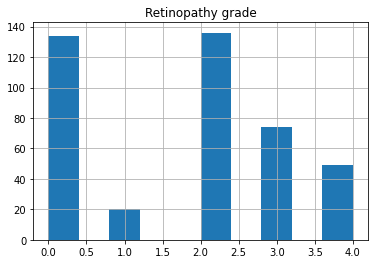

In [6]:
train_df.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc81cfc6a90>]],
      dtype=object)

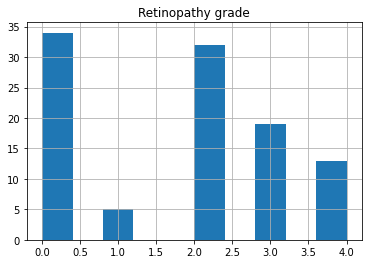

In [7]:
test_df.hist()

In [8]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 680 Old Size: 413


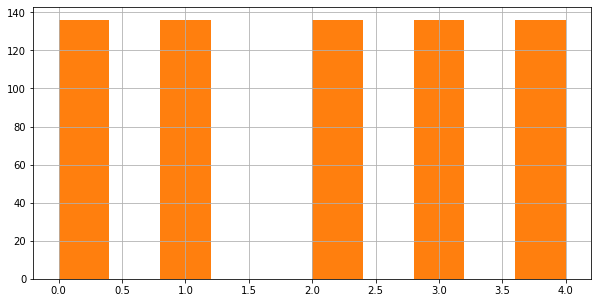

In [9]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [10]:
train_df['Retinopathy grade']=train_df['Retinopathy grade'].astype('str')
test_df['Retinopathy grade']=test_df['Retinopathy grade'].astype('str')

In [20]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    IMG_WIDTH=380
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            img = cv2.resize(img, (IMG_WIDTH, IMG_WIDTH))
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    IMG_WIDTH=380
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    #image = cv2.resize(image, (IMG_WIDTH, IMG_WIDTH))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

### show images without preprocess but just crop

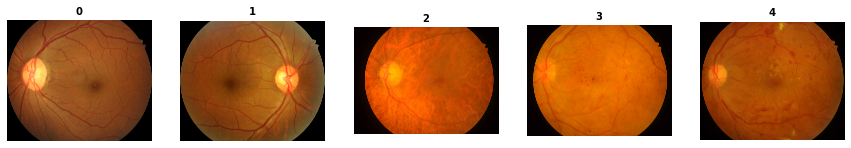

In [12]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['Retinopathy grade'] == str(i)].sample(1)
    image_name = sample['Image name'].item()
    X = crop_image_from_gray(imread((image_name)))
    ax[i].set_title((str(i)), weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [23]:
# We use a small batch size so we can handle large images easily
BATCH_SIZE = 8
IMG_WIDTH, IMG_HEIGHT=380,380

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.10,
                                   zoom_range=[0.75,1],
                                   width_shift_range=1.1,
                                   height_shift_range=0.05,
                                   fill_mode='nearest',
                                   preprocessing_function= crop_image_from_gray
                                )

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='Image name', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                       
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='Image name', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  subset='validation')

Found 612 validated image filenames belonging to 5 classes.
Found 68 validated image filenames belonging to 5 classes.


In [24]:
from tensorflow.keras.applications import EfficientNetB4
import keras.backend as K
IMG_SIZE=380
def output_relu(x):
    return K.relu(x, max_value=4)
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable=False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2,name='global_dropout')(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2,name='dense_dropout')(x)
x = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 380, 380, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 380, 380, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 380, 380, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 381, 381, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [26]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='auto', verbose=1, patience=5)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.01)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3,beta_1=0.8), loss='categorical_crossentropy',metrics=['acc'])
model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=50,
                    validation_data=val_generator,
                    callbacks=[es,rlr]
                    ) 

Epoch 1/50
77/77 [==============================] - 197s 2s/step - loss: 1.5215 - acc: 0.3123 - val_loss: 1.1506 - val_acc: 0.4559
Epoch 2/50
77/77 [==============================] - 109s 1s/step - loss: 1.1610 - acc: 0.5213 - val_loss: 0.9973 - val_acc: 0.5882
Epoch 3/50
77/77 [==============================] - 109s 1s/step - loss: 0.9609 - acc: 0.5768 - val_loss: 0.9961 - val_acc: 0.4853
Epoch 4/50
77/77 [==============================] - 108s 1s/step - loss: 1.1024 - acc: 0.5116 - val_loss: 0.8859 - val_acc: 0.6324
Epoch 5/50
77/77 [==============================] - 108s 1s/step - loss: 0.9006 - acc: 0.6066 - val_loss: 1.1025 - val_acc: 0.4706
Epoch 6/50
77/77 [==============================] - 108s 1s/step - loss: 0.8088 - acc: 0.6615 - val_loss: 0.9543 - val_acc: 0.5441
Epoch 7/50
77/77 [==============================] - 109s 1s/step - loss: 0.8520 - acc: 0.6584 - val_loss: 0.8509 - val_acc: 0.6765
Epoch 8/50
77/77 [==============================] - 108s 1s/step - loss: 0.8461 - a

KeyboardInterrupt: ignored

[[18  2  0  0  0]
 [ 0 12  0  0  0]
 [ 1  2  4  3  0]
 [ 0  0  1  5  2]
 [ 0  0  1  2 11]]
0.78125  accuracy


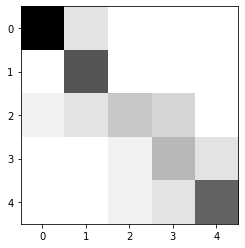

In [29]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_=np.zeros((len(val_generator)*8-8,5))
val_labels=np.zeros((len(val_generator)*8-8,5)) 

for i,(img,lbl) in enumerate(val_generator):
  if i==len(val_generator)-2:
    break
  pred_y_[8*i:8*i+8]=model.predict(img)
  val_labels[8*i:i*8+8]=lbl

cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))," accuracy")

In [53]:
# Add Image augmentation to our generator
test_datagen = ImageDataGenerator(
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.10,
                                   zoom_range=[0.75,1],
                                   fill_mode='nearest',
                                   preprocessing_function=crop_image_from_gray 
                                )

# Use the dataframe to define train and validation generators
test_generator = test_datagen.flow_from_dataframe(test_df, 
                                                    x_col='Image name', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=4)

Found 103 validated image filenames belonging to 5 classes.


[[11 13  6  1  1]
 [ 3  1  1  0  0]
 [ 3  3 18  6  1]
 [ 0  2  4 12  1]
 [ 1  0  2  6  4]]
0.46  accuracy


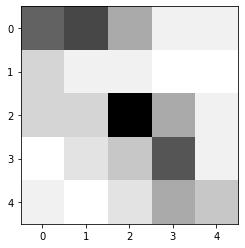

In [36]:
pred_y_1=np.zeros((len(test_generator)*4-4,5))
test_labels=np.zeros((len(test_generator)*4-4,5)) 

for i,(img,lbl) in enumerate(test_generator):
  if i==len(test_generator)-1:
    break
  pred_y_1[4*i:4*i+4]=model.predict(img)
  test_labels[4*i:i*4+4]=lbl
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_1,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_1,axis=1))," accuracy")

## unfreeze and train

In [39]:
model.trainable=True
trainable_count = count_params(model.trainable_weights)
print("Trainable weights ",trainable_count)
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='auto', verbose=1, patience=5)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.01)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.8), loss='categorical_crossentropy',metrics=['acc'])
model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=50,
                    validation_data=val_generator,
                    callbacks=[es,rlr]
                    )

Trainable weights  18008909
Epoch 1/50
77/77 [==============================] - 143s 2s/step - loss: 1.0124 - acc: 0.5916 - val_loss: 0.6912 - val_acc: 0.6912
Epoch 2/50
77/77 [==============================] - 126s 2s/step - loss: 0.7552 - acc: 0.6757 - val_loss: 0.6653 - val_acc: 0.7794
Epoch 3/50
77/77 [==============================] - 126s 2s/step - loss: 0.7353 - acc: 0.7194 - val_loss: 0.5999 - val_acc: 0.8382
Epoch 4/50
77/77 [==============================] - 126s 2s/step - loss: 0.5082 - acc: 0.8026 - val_loss: 0.6606 - val_acc: 0.8088
Epoch 5/50
77/77 [==============================] - 126s 2s/step - loss: 0.5744 - acc: 0.8022 - val_loss: 0.5111 - val_acc: 0.8088
Epoch 6/50
77/77 [==============================] - 127s 2s/step - loss: 0.4397 - acc: 0.8554 - val_loss: 0.5766 - val_acc: 0.8235
Epoch 7/50
77/77 [==============================] - 126s 2s/step - loss: 0.4007 - acc: 0.8555 - val_loss: 0.3389 - val_acc: 0.9118
Epoch 8/50
77/77 [==============================] - 126

[[28  2  2  0  1]
 [ 4  1  0  0  0]
 [ 4  1 21  2  3]
 [ 1  0  6  9  3]
 [ 3  0  5  1  3]]
0.62  accuracy


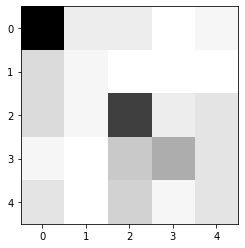

In [50]:
pred_y_2=np.zeros((len(test_generator)*4-4,5))
test_labels_2=np.zeros((len(test_generator)*4-4,5)) 

for i,(img,lbl) in enumerate(test_generator):
  if i==len(test_generator)-1:
    break
  pred_y_2[4*i:4*i+4]=model.predict(img)
  test_labels_2[4*i:i*4+4]=lbl

cm=confusion_matrix(np.argmax(test_labels_2,axis=1),np.argmax(pred_y_2,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(test_labels_2,axis=1),np.argmax(pred_y_2,axis=1))," accuracy")

##progressive resize

In [58]:
base_model_ = EfficientNetB4(weights=None, include_top=False, input_shape=(IMG_SIZE*2,IMG_SIZE*2,3))
base_model_.trainable=False
x = base_model_.output
x = layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(5, activation='softmax')(x)
model_resize = Model(inputs=base_model_.input, outputs=x)
model_resize.set_weights(model.get_weights()) 

In [77]:
def crop_image_from_gray_1(img, tol=7):
    IMG_WIDTH=380*2
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            img = cv2.resize(img, (IMG_WIDTH, IMG_WIDTH))
        return img

# We use a small batch size so we can handle large images easily

# Add Image augmentation to our generator
train_datagen_re = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.10,
                                   zoom_range=[0.75,1],
                                   width_shift_range=1.1,
                                   height_shift_range=0.05,
                                   fill_mode='nearest',
                                   preprocessing_function=crop_image_from_gray_1
                                )
# Use the dataframe to define train and validation generators
train_generator_re = train_datagen_re.flow_from_dataframe(train_df, 
                                                    x_col='Image name', 
                                                    y_col='Retinopathy grade',
                                                    target_size=(IMG_WIDTH*2, IMG_HEIGHT*2),
                                                    batch_size=int(BATCH_SIZE/2),
                                                    subset='training')

val_generator_re = train_datagen_re.flow_from_dataframe(train_df, 
                                                  x_col='Image name', 
                                                  y_col='Retinopathy grade',
                                                  target_size=(IMG_WIDTH*2, IMG_HEIGHT*2),
                                                  batch_size=int(BATCH_SIZE/2),
                                                  subset='validation')

Found 612 validated image filenames belonging to 5 classes.
Found 68 validated image filenames belonging to 5 classes.


In [61]:
trainable_count = count_params(model_resize.trainable_weights)
print("Trainable weights ",trainable_count)
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='auto', verbose=1, patience=5)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, patience=4, 
                        verbose=1, mode='auto', 
                        min_delta=0.01)
model_resize.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.8), loss='categorical_crossentropy',metrics=['acc'])
model_resize.fit(train_generator_re,
                    steps_per_epoch=len(train_generator),
                    epochs=25,
                    validation_data=val_generator_re,
                    callbacks=[es,rlr]
                    )

Trainable weights  460293
Epoch 1/25
77/77 [==============================] - 201s 2s/step - loss: 0.6552 - acc: 0.7249 - val_loss: 0.5968 - val_acc: 0.8382
Epoch 2/25
77/77 [==============================] - 185s 2s/step - loss: 0.5075 - acc: 0.7915 - val_loss: 0.4170 - val_acc: 0.8529
Epoch 3/25
77/77 [==============================] - 184s 2s/step - loss: 0.3913 - acc: 0.8352 - val_loss: 0.5494 - val_acc: 0.8382
Epoch 4/25
77/77 [==============================] - 184s 2s/step - loss: 0.3540 - acc: 0.8657 - val_loss: 0.5935 - val_acc: 0.8382
Epoch 5/25
77/77 [==============================] - 185s 2s/step - loss: 0.3814 - acc: 0.8608 - val_loss: 0.5281 - val_acc: 0.8529
Epoch 6/25
77/77 [==============================] - 186s 2s/step - loss: 0.3761 - acc: 0.8575 - val_loss: 0.5331 - val_acc: 0.8529

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/25
77/77 [==============================] - 186s 2s/step - loss: 0.2803 - acc: 0.8982 - val_loss: 0

In [65]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic') 


[[29  0  4  0  0]
 [ 4  1  0  0  0]
 [ 5  2 18  7  0]
 [ 2  0  5  9  1]
 [ 3  0  3  3  4]]
0.61  accuracy
quadratic kappa  0.6480331262939958


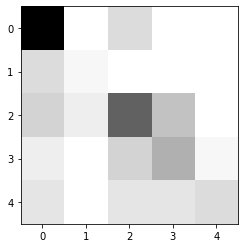

In [71]:
pred_y_2=np.zeros((len(test_generator)*4-4,5))
test_labels_2=np.zeros((len(test_generator)*4-4,5)) 

for i,(img,lbl) in enumerate(test_generator):
  if i==len(test_generator)-1:
    break
  pred_y_2[4*i:4*i+4]=model.predict(img)
  test_labels_2[4*i:i*4+4]=lbl

cm=confusion_matrix(np.argmax(test_labels_2,axis=1),np.argmax(pred_y_2,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(test_labels_2,axis=1),np.argmax(pred_y_2,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_2,axis=1),np.argmax(test_labels_2,axis=1)))

In [78]:
model_resize.trainable=True
trainable_count = count_params(model_resize.trainable_weights)
print("Trainable weights ",trainable_count)
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='auto', verbose=1, patience=4)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        min_delta=0.01)
model_resize.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.8), loss='categorical_crossentropy',metrics=['acc'])
model_resize.fit(train_generator_re,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_data=val_generator_re,
                    callbacks=[es,rlr]
                    )

Trainable weights  18008909
Epoch 1/15
77/77 [==============================] - 159s 2s/step - loss: 1.0558 - acc: 0.6152 - val_loss: 0.6233 - val_acc: 0.7941
Epoch 2/15
77/77 [==============================] - 138s 2s/step - loss: 0.7936 - acc: 0.7076 - val_loss: 0.6194 - val_acc: 0.8529
Epoch 3/15
77/77 [==============================] - 138s 2s/step - loss: 0.6277 - acc: 0.7595 - val_loss: 0.7018 - val_acc: 0.8382
Epoch 4/15
77/77 [==============================] - 137s 2s/step - loss: 0.3614 - acc: 0.8661 - val_loss: 0.5692 - val_acc: 0.7941
Epoch 5/15
77/77 [==============================] - 138s 2s/step - loss: 0.4146 - acc: 0.8530 - val_loss: 0.4656 - val_acc: 0.9118
Epoch 6/15
77/77 [==============================] - 138s 2s/step - loss: 0.4467 - acc: 0.8308 - val_loss: 0.5856 - val_acc: 0.8382
Epoch 7/15
77/77 [==============================] - 138s 2s/step - loss: 0.3766 - acc: 0.8515 - val_loss: 0.5468 - val_acc: 0.8382
Epoch 8/15
77/77 [==============================] - 138

[[27  2  4  0  0]
 [ 5  0  0  0  0]
 [ 5  1 22  4  0]
 [ 1  0  5 11  0]
 [ 3  0  5  1  4]]
0.64  accuracy
quadratic kappa  0.6467479236328336


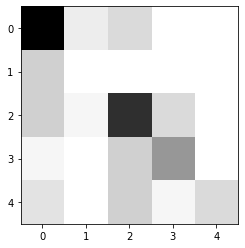

In [94]:
pred_y_2=np.zeros((len(test_generator)*4-4,5))
test_labels_2=np.zeros((len(test_generator)*4-4,5)) 

for i,(img,lbl) in enumerate(test_generator):
  if i==len(test_generator)-1:
    break
  pred_y_2[4*i:4*i+4]=model.predict(img)
  test_labels_2[4*i:i*4+4]=lbl

cm=confusion_matrix(np.argmax(test_labels_2,axis=1),np.argmax(pred_y_2,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(test_labels_2,axis=1),np.argmax(pred_y_2,axis=1))," accuracy")
print("quadratic kappa ",quadratic_kappa(np.argmax(pred_y_2,axis=1),np.argmax(test_labels_2,axis=1)))

In [80]:
# serialize model to JSON
model_json = model_resize.to_json()
with open("/content/drive/My Drive/IDRid/model_eff4_progr_resize(680*680).json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_resize.save_weights("/content/drive/My Drive/IDRid/model_eff4_progr_resize(680*680).h5")
print("Saved model to disk")

Saved model to disk
